# **Fake vs Real Job Detection**

## **Introduction**

With the rise of digital job postings, fraudulent job listings have become a major issue, tricking job seekers into scams and compromising their personal information. Fake job postings not only waste applicants' time but also pose financial and security risks. The goal of this project is to build a machine learning model that can classify job postings as real or fake based on various textual and categorical features.

## **Business Impact**

* For Job Seekers: Helps them avoid scams and protects personal information.

* For Recruitment Platforms: Enables automated filtering of fake listings, improving trust in the platform.

* For Companies: Protects employer branding by preventing fraudulent job postings under their name.

### Dataset Overview

The dataset consists of job postings labeled as fraudulent or legitimate. It includes multiple features such as job title, location, company profile, job description, required qualifications, telecommuting options, and more.

#### **Key Features:**

* Text-based Attributes: Job description, company profile, and requirements.

* Categorical Features: Employment type, required experience, required education.

* Boolean Indicators: Whether the job allows telecommuting, has a company logo, or includes screening questions.

* Target Variable: 'Fraudulent' (1 = Fake Job, 0 = Real Job)

### 1. Importing Libraries & Understanding Data

In [1]:
#Importing Libraries
import re
import string
import numpy as np
import pandas as pd
import random
import missingno
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder 
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.svm import SVC

In [2]:
# Load dataset
data = pd.read_csv('fake_job_postings.csv')

In [3]:
# Display first few rows
data.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


#### 1.1 Initial Data Inspection

In [4]:
# Basic information about dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

The first few rows of the dataset provide a glimpse of what the data looks like. Key observations:

- The dataset contains job-related information such as title, location, description, and requirements.

- Some fields like company_profile and salary_range may have missing values.

- The fraudulent column is our target variable, indicating whether a job is fake or real.

In [5]:
# Summary statistics
data.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


- The telecommuting feature has a mean close to 0.04, indicating that most jobs are not remote.

- About 79% of the jobs have a company logo (has_company_logo feature).

- The target variable fraudulent has a mean of 0.048, meaning around 4.8% of jobs are labeled as fake.

- The has_questions column has a mean close to 0.49, showing that nearly half of the job postings include screening questions.

### 2. Data Preprocesing

**2.1 Selecting Relevant Columns**

We focus on the key attributes that are most relevant to determining whether a job posting is fraudulent.

In [6]:
# Selecting relevant columns
data = data[['title', 'location', 'company_profile', 'requirements', 'benefits', 'telecommuting', 'description', 'has_company_logo', 'has_questions', 'employment_type',
'required_experience', 'required_education', 'industry', 'function', 'salary_range','fraudulent']]


**2.2 Checking for Duplicates**

Duplicate job postings can introduce bias in our analysis and model training, so we check and remove them if necessary.

In [7]:
# Checking for duplicates
duplicates = data.duplicated().sum()
print(f'Total Duplicates: {duplicates}')

# Dropping duplicates
data.drop_duplicates(inplace=True)
print(f'Duplicates after removal: {data.duplicated().sum()}')

Total Duplicates: 283
Duplicates after removal: 0


**2.3 Separating Numerical and Categorical Features**

To facilitate exploratory data analysis (EDA) and model training, we separate numerical and categorical features.

In [8]:
# Separating numerical and categorical features
data_num = data[['telecommuting','has_company_logo','has_questions','fraudulent','salary_range']]
data_categ = data[['title', 'location', 'company_profile', 'requirements', 'description', 'benefits', 'employment_type','required_experience', 'required_education', 'industry', 'function']]


**2.4 Handling Outliers**

To remove anomalies in numerical data, we filter extreme values:

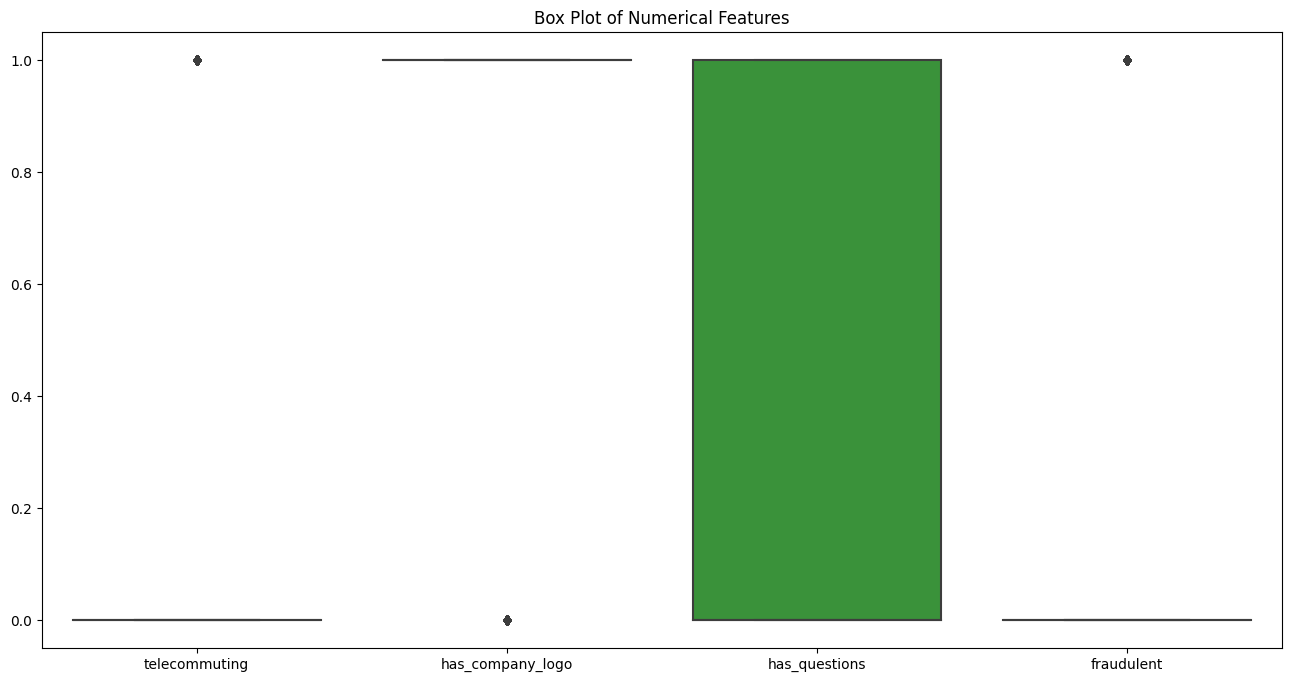

In [9]:
# Box plot for numerical features
plt.figure(figsize=(16,8))
sns.boxplot(data=data_num)
plt.title("Box Plot of Numerical Features")
plt.show()

***Analysis:***

- The boxplot highlights the distribution of numerical features, showing potential outliers in attributes like salary_range.

- Features such as telecommuting, has_company_logo, and has_questions are binary (0 or 1), and their distribution will be useful for identifying patterns in fraudulent job postings.

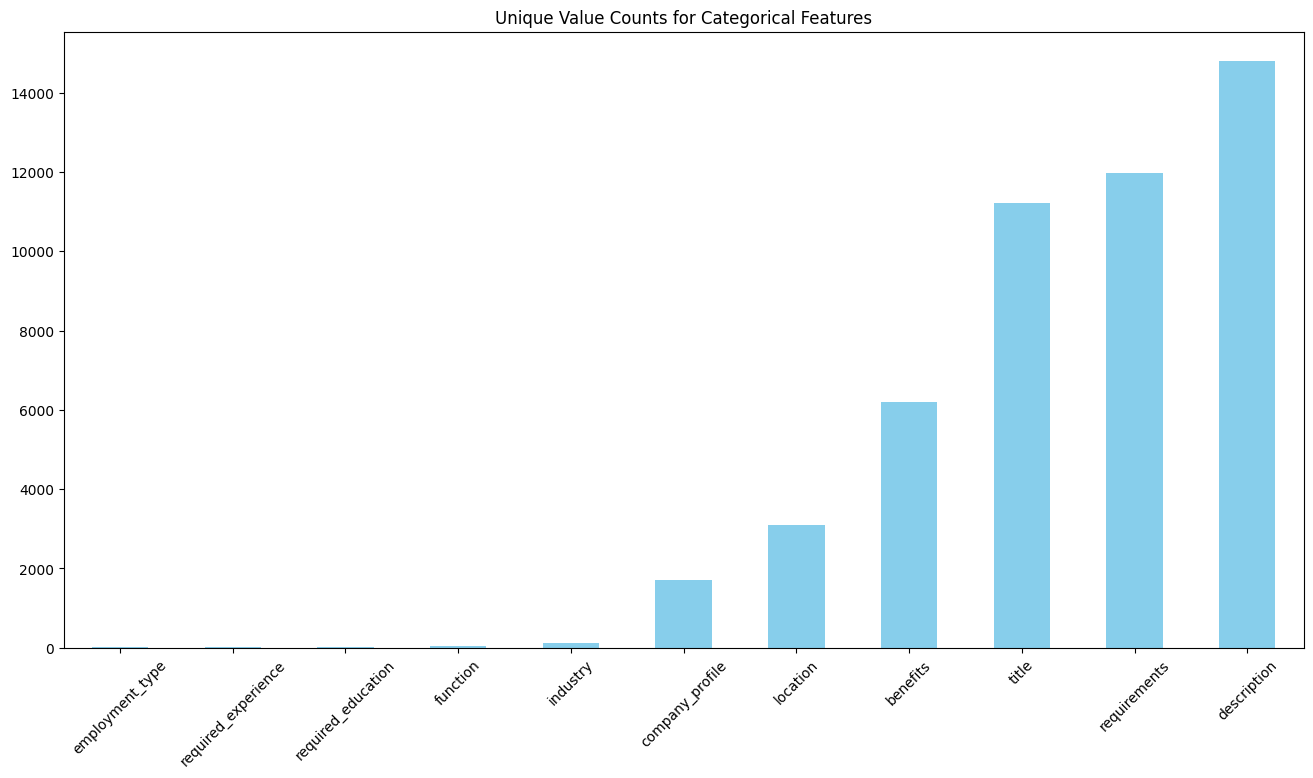

In [10]:
# Bar plot for categorical feature distributions
plt.figure(figsize=(16,8))
data_categ.nunique().sort_values().plot(kind='bar', color='skyblue')
plt.title("Unique Value Counts for Categorical Features")
plt.xticks(rotation=45)
plt.show()

***Analysis:***

- Some categorical features have a high number of unique values, such as job titles and requirements.

- Certain industries and job functions may have a higher proportion of fraudulent listings, which we will analyze further.

In [11]:
# removing outliers

data_num = data_num[data_num['telecommuting'] < 0.9]
data_num = data_num[data_num['has_company_logo'] > 0.1]
data_num = data_num[data_num['fraudulent'] < 0.9]

data_num

,telecommuting,has_company_logo,has_questions,fraudulent,salary_range
0,0,1,0,0,NaN
1,0,1,0,0,NaN
2,0,1,0,0,NaN
3,0,1,0,0,NaN
4,0,1,1,0,NaN
...,...,...,...,...,...
17872,0,1,0,0,NaN
17873,0,1,0,0,NaN
17875,0,1,1,0,NaN
17876,0,1,1,0,NaN


**2.5 Handling Missing Values**

Missing values can reduce model accuracy, so we check and remove rows with missing values:

In [12]:
data.isnull().sum()

title                      0
location                 341
company_profile         3282
requirements            2649
benefits                7108
telecommuting              0
description                1
has_company_logo           0
has_questions              0
employment_type         3428
required_experience     6962
required_education      8009
industry                4837
function                6363
salary_range           14771
fraudulent                 0
dtype: int64

In [13]:
data.dropna(axis=0, how='any', inplace=True)
data.isnull().sum()

title                  0
location               0
company_profile        0
requirements           0
benefits               0
telecommuting          0
description            0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
salary_range           0
fraudulent             0
dtype: int64

In [14]:
data.shape

(1258, 16)

### 3. Exploratory Data Analysis (EDA)

EDA helps us understand the structure of the dataset and uncover patterns or anomalies that might affect the model’s performance.

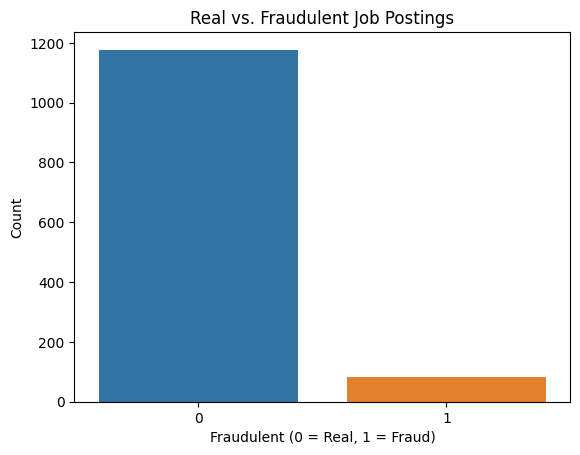

,fraudulent,title
0,0,1177
1,1,81


In [15]:
# Corrected count plot for fraudulent vs. real job postings
sns.countplot(x='fraudulent', data=data)
plt.title('Real vs. Fraudulent Job Postings')
plt.xlabel('Fraudulent (0 = Real, 1 = Fraud)')
plt.ylabel('Count')
plt.show()

# Grouping data by 'fraudulent' column to count the number of job titles in each category
fraud_real_counts = data.groupby('fraudulent')['title'].count().reset_index().sort_values(by='title', ascending=False)

# Display the count summary
fraud_real_counts

In [16]:
print(f'Categorical Columns in the dataset: \n {data_categ.columns} \n')
print(f'Numerical Columns in the dataset: \n {data_num.columns}')

Categorical Columns in the dataset: 
 Index(['title', 'location', 'company_profile', 'requirements', 'description',
       'benefits', 'employment_type', 'required_experience',
       'required_education', 'industry', 'function'],
      dtype='object') 

Numerical Columns in the dataset: 
 Index(['telecommuting', 'has_company_logo', 'has_questions', 'fraudulent',
       'salary_range'],
      dtype='object')


#### **Distribution of Employment Type**

Understanding the distribution of job types helps identify patterns that may indicate fraudulent postings.


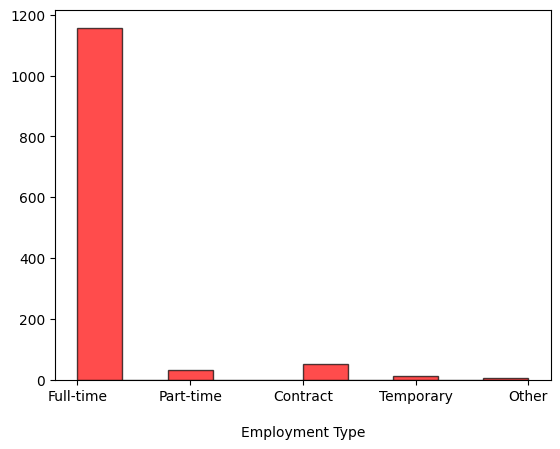

In [17]:
plt.hist(data.employment_type, color='red', edgecolor='black', alpha=0.7)
plt.xlabel('\nEmployment Type')
plt.show()


From the above graph it can be seen that the Full time Opportunities have the maximum number of fradulent openenings.

#### **Distribution of Required Experience**
Analyzing the required experience levels can provide insights into job posting trends and potential fraud indicators.

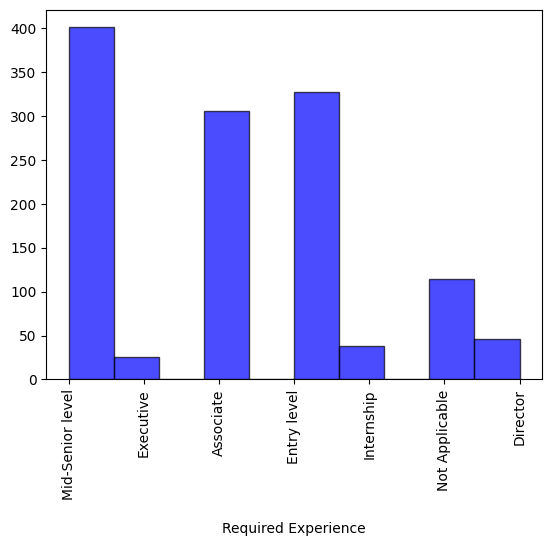

In [18]:
# Plotting the distribution of required experience
plt.hist(data.required_experience, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('\nRequired Experience')
plt.xticks(rotation=90)
plt.show()


#### **Frequency of Fraudulent Job Postings**
Understanding the Frequency of distribution of fraudulent vs. real job postings helps in assessing class imbalance in the dataset.

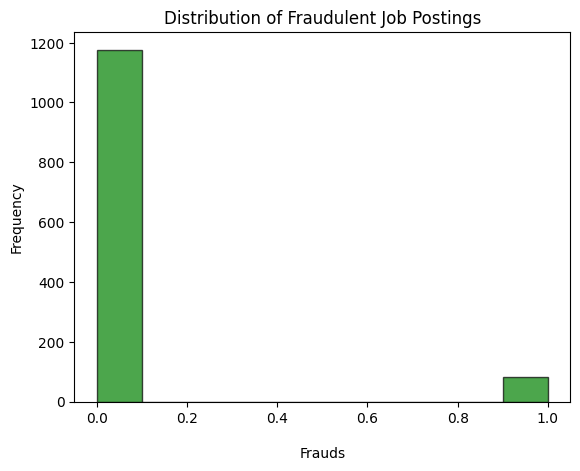

In [19]:
# Plotting the distribution of fraudulent job postings
plt.hist(data['fraudulent'], color='green', edgecolor='black', alpha=0.7)
plt.xlabel('\nFrauds')
plt.ylabel('Frequency')
plt.title('Distribution of Fraudulent Job Postings')
plt.show()

#### **Distribution of Job Functions**
Analyzing the distribution of job sectors helps in understanding which roles are more common in the dataset.

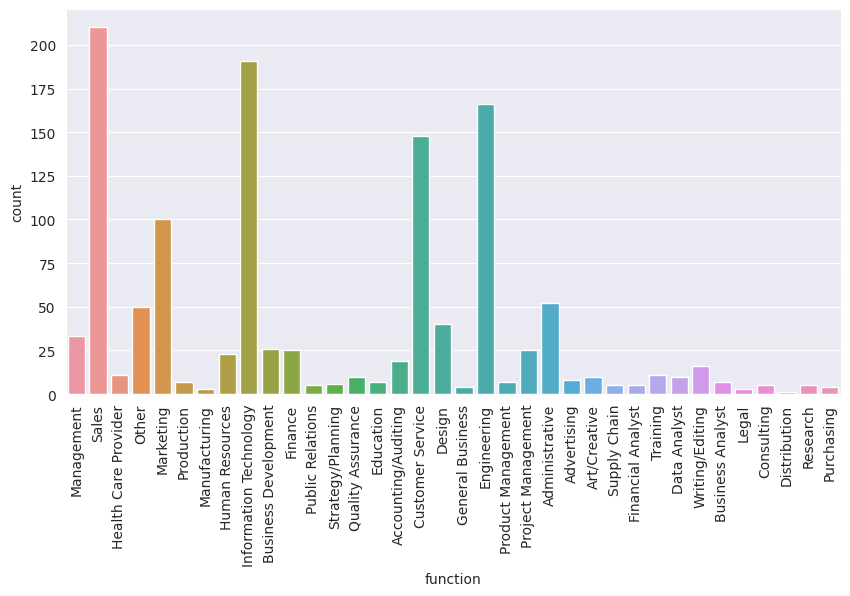

In [20]:
plt.figure(figsize=(10,5))
sns.set_style('darkgrid')
sns.countplot(x='function' ,data=data)
plt.xticks(rotation=90)
plt.show()

Text(0.5, 0, 'Countries')

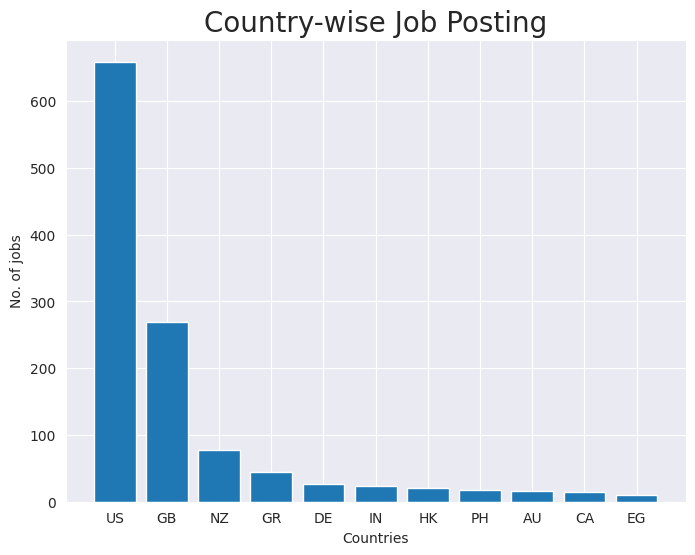

In [21]:
#Visualize job postings by countries
def split(location):
    l = location.split(',')
    return l[0]

data['country'] = data.location.apply(split)

country = dict(data.country.value_counts()[:11])
#del country[' ']
plt.figure(figsize=(8,6))
plt.title('Country-wise Job Posting', size=20)
plt.bar(country.keys(), country.values())
plt.ylabel('No. of jobs', size=10)
plt.xlabel('Countries', size=10)

#### **Filtering Full-Time Real Jobs**

In [22]:

# Extracting only full-time legitimate job postings
data_jobs_fulltime = data[(data['employment_type'] == 'Full-time') & (data['fraudulent'] == 0)]

# Displaying the number of such jobs
data_jobs_fulltime.shape


(1083, 17)

#### **Most Common Job Titles in Full-Time Real Jobs**

In [23]:
# Counting occurrences of each job title in full-time legitimate postings
data_jobs_fulltime['title'].value_counts()

title
Agent-Inbound Sales Position                                12
Marketing Manager                                            8
Customer Service Representative                              8
Account Manager                                              7
Technical Support Associate                                  7
                                                            ..
Information Technology Sales Professional                    1
Sales Executive for Content Marketing Firm                   1
Graduate application - HW Design                             1
Tech Support Specialist                                      1
Portfolio Development Associate - Paris & rest of France     1
Name: count, Length: 861, dtype: int64

### Observation:
**'Agent-Inbound Sales Position' has the highest number of full-time legitimate job postings (12).**


#### **Industries with the Most Fake Job Postings**

In [24]:
# Filtering dataset for fraudulent job postings
data_industry_mostfake = data[data['fraudulent'] == 1]

# Checking the number of fraudulent job postings
data_industry_mostfake.shape


(81, 17)

#### **Industry Analysis for Fake Job Postings**

In [25]:
# Counting the number of fake job postings per industry
data_industry_mostfake['industry'].value_counts()


industry
Oil & Energy                            19
Real Estate                             10
Consumer Services                        9
Financial Services                       6
Computer & Network Security              5
Retail                                   4
Management Consulting                    3
Hospitality                              2
Insurance                                2
Accounting                               2
Telecommunications                       2
Human Resources                          2
Transportation/Trucking/Railroad         2
Hospital & Health Care                   2
Defense & Space                          1
Media Production                         1
Computer Networking                      1
Mechanical or Industrial Engineering     1
Military                                 1
Information Services                     1
Logistics and Supply Chain               1
Warehousing                              1
Security and Investigations              1
Co

***Oil & Energy is the industry with the most fake jobs (19), followed by Real Estate (10).***

### **Visualizing the fraud and Real Jobs text using Word Cloud**

In [26]:
data.columns

Index(['title', 'location', 'company_profile', 'requirements', 'benefits',
       'telecommuting', 'description', 'has_company_logo', 'has_questions',
       'employment_type', 'required_experience', 'required_education',
       'industry', 'function', 'salary_range', 'fraudulent', 'country'],
      dtype='object')

In [27]:
# Ensure missing values are replaced with an empty string before concatenation
text_cols = ['title', 'location', 'company_profile', 'description', 'requirements', 'benefits']

for col in text_cols:
    data[col] = data[col].fillna('')

# Combine all text-related columns into a single 'text' column
data['text'] = data['title'] + ' ' + data['location'] + ' ' + data['company_profile'] + ' ' + \
               data['description'] + ' ' + data['requirements'] + ' ' + data['benefits']

# Drop unnecessary columns to keep dataset clean
# cols_to_drop = ['location', 'department', 'company_profile', 'description', 'requirements', 
#                 'benefits', 'required_experience', 'required_education', 'industry', 'function', 'country']

# data.drop(columns=[col for col in cols_to_drop if col in data.columns], inplace=True)


In [28]:
# Verify changes
print("Columns after cleaning:", data.columns)
data['text'].head() # Preview the combined text column

Columns after cleaning: Index(['title', 'location', 'company_profile', 'requirements', 'benefits',
       'telecommuting', 'description', 'has_company_logo', 'has_questions',
       'employment_type', 'required_experience', 'required_education',
       'industry', 'function', 'salary_range', 'fraudulent', 'country',
       'text'],
      dtype='object')


6     Head of Content (m/f) DE, BE, Berlin Founded i...
15    VP of Sales - Vault Dragon SG, 01, Singapore J...
23    Vice President, Sales and Sponsorship (Busines...
76    Medical Coder US, TX, Fort Worth SpotSource So...
98    IC&E Technician US, , Stocton, CA             ...
Name: text, dtype: object

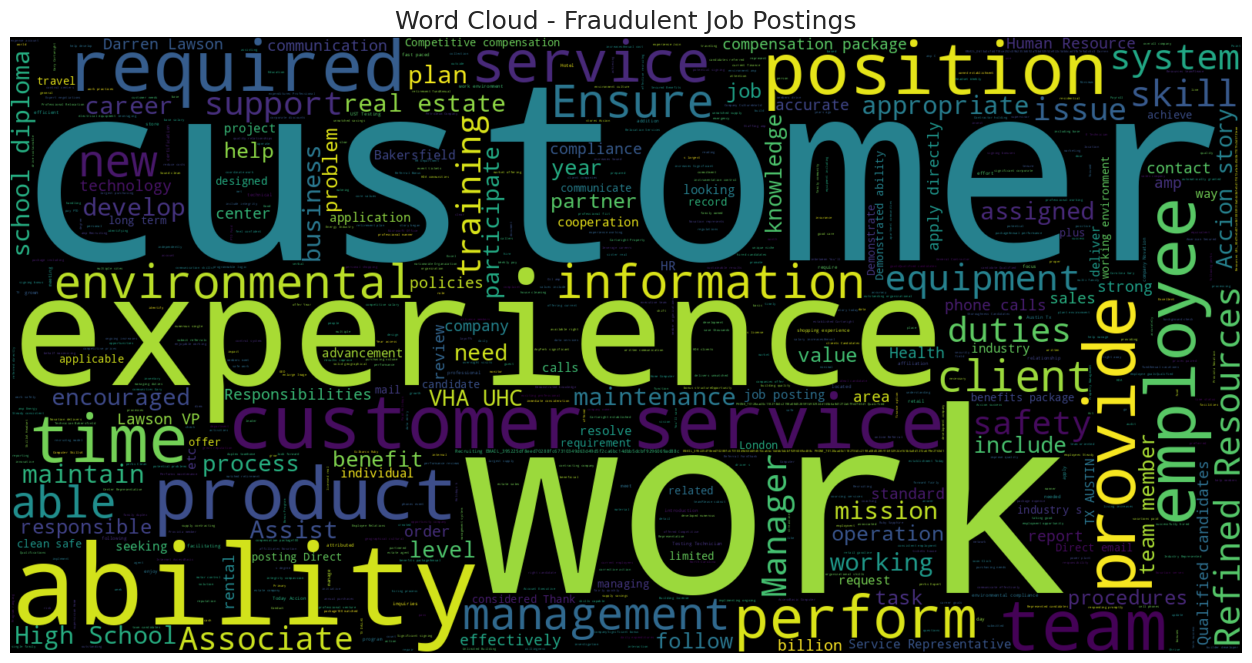

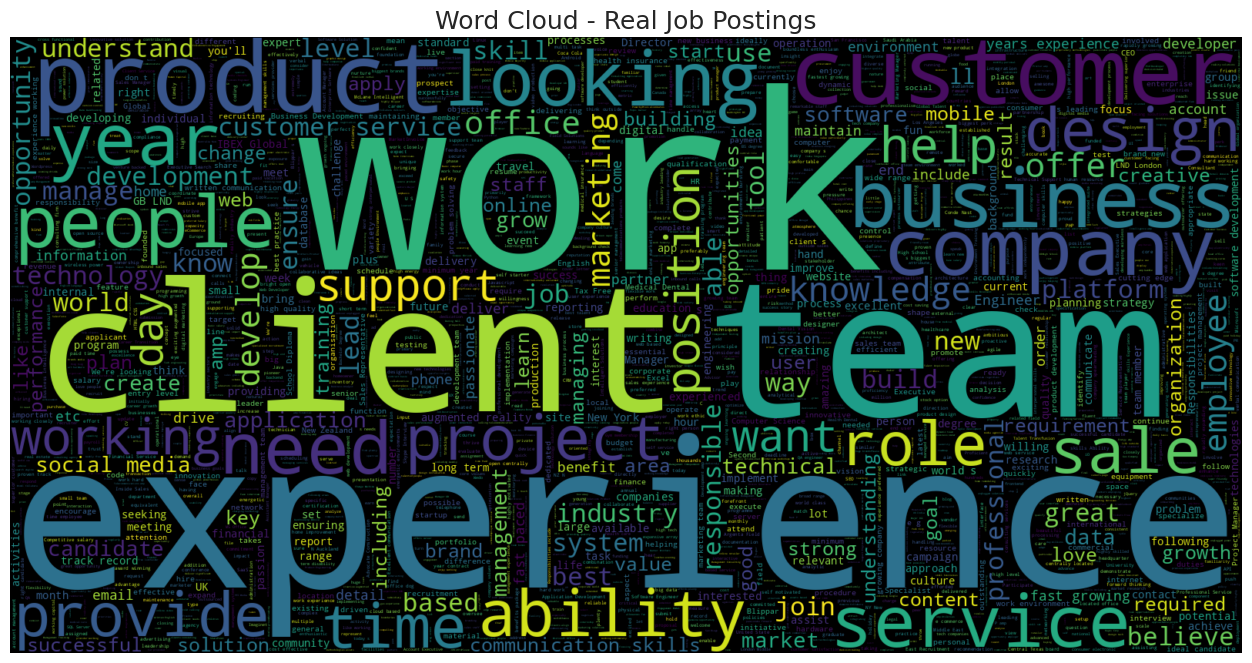

In [29]:
from wordcloud import WordCloud
import spacy
import matplotlib.pyplot as plt

# Ensure 'text' column exists; adjust if your dataset uses a different column name
if 'text' not in data.columns:
    raise KeyError("Column 'text' not found in dataset. Check the correct column name.")

# Separate fraudulent and real job descriptions
fraudjobs_text = " ".join(data[data['fraudulent'] == 1]['text'].dropna())
actualjobs_text = " ".join(data[data['fraudulent'] == 0]['text'].dropna())

# Define stopwords using spaCy
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

# Fraudulent jobs word cloud
plt.figure(figsize=(16, 8))
wc_fraud = WordCloud(min_font_size=3, max_words=3000, width=1600, height=800, 
                     stopwords=STOPWORDS, background_color="black").generate(fraudjobs_text)
plt.imshow(wc_fraud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud - Fraudulent Job Postings", fontsize=18)
plt.show()

# Actual jobs word cloud
plt.figure(figsize=(16, 8))
wc_actual = WordCloud(min_font_size=3, max_words=3000, width=1600, height=800, 
                      stopwords=STOPWORDS, background_color="black").generate(actualjobs_text)
plt.imshow(wc_actual, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud - Real Job Postings", fontsize=18)
plt.show()


## 4. Feature Engineering

#### **4.1 Fraudulent Job Distribution**

In [30]:
# Counting the number of real vs. fake job postings
data['fraudulent'].value_counts()


fraudulent
0    1177
1      81
Name: count, dtype: int64

***The dataset contains 1,403 real job postings and 82 fraudulent job postings.***

In [31]:
#Separating Fraudulent and Real Jobs
fraud_jobs = data[data['fraudulent'] == 1]
real_jobs = data[data['fraudulent'] == 0]

fraud_jobs.shape, real_jobs.shape


((81, 18), (1177, 18))

***The dataset contains 82 fraudulent job postings and 1,403 real job postings.***

In [32]:
#Oversampling Fraudulent Job Postings for a Balanced Dataset
fraud_jobs = fraud_jobs.sample(1403, replace=True)

fraud_jobs.shape, real_jobs.shape


((1403, 18), (1177, 18))

***After oversampling, both fraudulent and real job postings have 1,403 samples each, ensuring a balanced dataset.***

In [33]:
# Oversampling Fraudulent Job Postings for a Balanced Dataset
fraud_jobs = fraud_jobs.sample(1403, replace=True)

# Combining Oversampled Fraudulent Jobs with Real Jobs
data = pd.concat([fraud_jobs, real_jobs])

# Reset index
data.reset_index(drop=True, inplace=True)

# Display first few rows
data.head()



,title,location,company_profile,requirements,benefits,telecommuting,description,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,salary_range,fraudulent,country,text
0,CUSTOMER SERVICES REP( FULL TIME POSITION),"US, TX, AUSTIN",Our globally connected world has forced busine...,Communication - communicates clearly and conci...,"Competitive compensation package, benefits and...",0,DescriptionDUTIES INCLUDE BUT ARE NOT LIMITED ...,1,1,Full-time,Entry level,High School or equivalent,Telecommunications,Customer Service,35000-40000,1,US,"CUSTOMER SERVICES REP( FULL TIME POSITION) US,..."
1,Production Assistant,"US, TX, Houston","Founded in 1993, our group has, in a few short...",Flexible ScheduleNo professional knowledge re...,compensation: 11.50/hr plus growth potential,0,"Operate machine tools such as lathes, milling ...",1,1,Full-time,Not Applicable,Unspecified,Media Production,Manufacturing,30000-34000,1,US,"Production Assistant US, TX, Houston Founded i..."
2,Sales Professional- SMB (Full-Time),"US, MD, Baltimore",Making Mobile Device Management Clear is Clear...,Job Requirements High School Diploma or GEDPas...,401kHealth InsurancePaid Time OffVacation Time...,0,- Maintain a high level of Clearmark solution ...,1,0,Full-time,Entry level,High School or equivalent,Computer & Network Security,Sales,21600-31200,1,US,"Sales Professional- SMB (Full-Time) US, MD, Ba..."
3,Customer Service Representative,"US, CA, Los Angeles",Gary Cartwright established Cartwright Propert...,Home Computer with Internet AccessBasic Comput...,"Weekly pay, PTO, Paid Holidays, 401 k",1,We are Seeking a candidate whose core values i...,1,0,Full-time,Entry level,High School or equivalent,Real Estate,Customer Service,30000-50000,1,US,"Customer Service Representative US, CA, Los An..."
4,Hotel Workers Needed,GB,"Hotel Verta, a luxury boutique hotel located o...",Relocation EligibleDegree/Certification holder...,SALARY AND BENEFITS: An attractive salary pack...,0,"Ref: HOVER-ORC-B55UK07-14Hotel Verta, a luxury...",1,0,Full-time,Not Applicable,High School or equivalent,Hospitality,Customer Service,3000-60000,1,GB,"Hotel Workers Needed GB Hotel Verta, a luxury ..."


**The dataset is now balanced and ready for further processing.**

#### **4.2 Encoding**

In [34]:
# Displaying categorical column names
data_categ.columns


Index(['title', 'location', 'company_profile', 'requirements', 'description',
       'benefits', 'employment_type', 'required_experience',
       'required_education', 'industry', 'function'],
      dtype='object')

In [35]:
# Encoding categorical variables
le = LabelEncoder()
data['title'] = le.fit_transform(data['title'])
data['location'] = le.fit_transform(data['location'])
data['company_profile'] = le.fit_transform(data['company_profile'])
data['requirements'] = le.fit_transform(data['requirements'])
data['employment_type'] = le.fit_transform(data['employment_type'])
data['required_experience'] = le.fit_transform(data['required_experience'])
data['required_education'] = le.fit_transform(data['required_education'])
data['industry'] = le.fit_transform(data['industry'])
data['function'] = le.fit_transform(data['function'])
data['salary_range'] = le.fit_transform(data['salary_range'])

# Reset index
data.reset_index(drop=True, inplace=True)

# Display first few rows
data.head()


,title,location,company_profile,requirements,benefits,telecommuting,description,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,salary_range,fraudulent,country,text
0,125,324,218,280,"Competitive compensation package, benefits and...",0,DescriptionDUTIES INCLUDE BUT ARE NOT LIMITED ...,1,1,1,2,4,78,7,260,1,US,"CUSTOMER SERVICES REP( FULL TIME POSITION) US,..."
1,672,338,130,1061,compensation: 11.50/hr plus growth potential,0,"Operate machine tools such as lathes, milling ...",1,1,1,6,9,54,21,222,1,US,"Production Assistant US, TX, Houston Founded i..."
2,772,261,196,484,401kHealth InsurancePaid Time OffVacation Time...,0,- Maintain a high level of Clearmark solution ...,1,0,1,2,4,10,31,166,1,US,"Sales Professional- SMB (Full-Time) US, MD, Ba..."
3,204,191,140,454,"Weekly pay, PTO, Paid Holidays, 401 k",1,We are Seeking a candidate whose core values i...,1,0,1,2,4,69,7,235,1,US,"Customer Service Representative US, CA, Los An..."
4,413,27,152,673,SALARY AND BENEFITS: An attractive salary pack...,0,"Ref: HOVER-ORC-B55UK07-14Hotel Verta, a luxury...",1,0,1,6,4,37,7,217,1,GB,"Hotel Workers Needed GB Hotel Verta, a luxury ..."


In [36]:
#Confirm the shape
data.shape

(2580, 18)

## **5. Model Building**

#### **5.1 Feature Selection and Target Variable**

Before training the machine learning model, we separate the dataset into features (X) and the target variable (y).

In [37]:
# Defining feature matrix (X) - Selecting relevant columns as input features
X = data[['title', 'location', 'company_profile', 'requirements', 
          'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
          'required_experience', 'required_education', 'industry', 'function',
          'salary_range']].values  

# Defining target variable (y) - Classifying jobs as real (0) or fraudulent (1)
y = data['fraudulent'].values  


**Splitting the Dataset into Training and Testing Sets**

To train and evaluate our machine learning model, we split the dataset into training and testing sets.

In [38]:
from sklearn.model_selection import train_test_split

# Splitting data into 67% training and 33% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Checking the shape of the split datasets
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((1728, 13), (852, 13), (1728,), (852,))

#### **5.2 Model Training**

#### **5.2.1 Logistic Regression**

In [39]:
from sklearn.linear_model import LogisticRegression 

# Initializing the Logistic Regression model with increased iterations for better convergence
lr = LogisticRegression(solver='lbfgs', max_iter=3000)

# Training the model on the training dataset
lr.fit(X_train, y_train)

# Making predictions on the test dataset
y_predict_lr = lr.predict(X_test)

In [40]:
from sklearn.metrics import accuracy_score 
print('Accuracy score using Logistic Regression :',accuracy_score(y_test ,y_predict_lr))

Accuracy score using Logistic Regression : 0.7875586854460094


#### **5.2.2 KNN**

In [41]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score

# Dictionary to store accuracy scores for different neighbor values
neighbors_with_accuracies = {}

# Iterating through different values of k (number of neighbors)
for i in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    
    # Predicting labels on the test set
    y_pred_knn = knn.predict(X_test)
    
    # Calculating accuracy
    acc = accuracy_score(y_test, y_pred_knn)
    
    # Storing accuracy for each k value
    neighbors_with_accuracies[i] = acc  

# Displaying accuracy values for different k values
print(neighbors_with_accuracies)

# Selecting the best k value based on maximum accuracy
best_k = max(neighbors_with_accuracies, key=neighbors_with_accuracies.get)
print("Best number of neighbors:", best_k)

# Training the model with the best k value
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

# Making predictions on the test set
y_predict_knn = knn.predict(X_test)

# Printing accuracy score
print("\n Accuracy Score using KNN:", accuracy_score(y_test, y_predict_knn))


{1: 0.9671361502347418, 2: 0.9671361502347418, 3: 0.9577464788732394, 4: 0.9553990610328639, 5: 0.9413145539906104, 6: 0.9413145539906104, 7: 0.931924882629108, 8: 0.931924882629108, 9: 0.92018779342723, 10: 0.92018779342723, 11: 0.9049295774647887, 12: 0.9061032863849765, 13: 0.8884976525821596, 14: 0.8767605633802817, 15: 0.857981220657277, 16: 0.8474178403755869, 17: 0.8415492957746479, 18: 0.8403755868544601, 19: 0.8356807511737089}
Best number of neighbors: 1

 Accuracy Score using KNN: 0.9671361502347418


#### **5.2.3 Random Forest**

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initializing the Random Forest Classifier
rf = RandomForestClassifier()

# Training the model on the training data
rf.fit(X_train, y_train)

# Making predictions on the test set
y_predict_rf = rf.predict(X_test)

# Printing accuracy score
print("Accuracy Score using Random Forest:", accuracy_score(y_test, y_predict_rf))


Accuracy Score using Random Forest: 0.9976525821596244


## **5. Model Evaluation**

Comparing Model Performance

We create a DataFrame to compare the accuracy scores of different models and determine which one performs the best.

In [43]:
import pandas as pd
from sklearn.metrics import accuracy_score

# Creating a DataFrame to store model names and their respective accuracy scores
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'KNN', 'Random Forest'],
    'Score': [
        accuracy_score(y_test, y_predict_lr),
        accuracy_score(y_test, y_predict_knn),
        accuracy_score(y_test, y_predict_rf)
    ]
})

# Sorting models based on accuracy score in descending order
models.sort_values(by='Score', ascending=False)


,Model,Score
2,Random Forest,0.997653
1,KNN,0.967136
0,Logistic Regression,0.787559


In [44]:
# Using the best-performing model (assume Random Forest performed best)
best_model = rf  # Change to 'knn' or 'lr' if needed
y_final_pred = best_model.predict(X_test)

# Show some predictions with actual labels
final_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_final_pred})
print(final_df.sample(10))  # Display random 10 predictions


     Actual  Predicted
337       0          0
327       0          0
521       0          0
156       1          1
611       0          0
68        0          0
794       0          0
39        0          0
179       0          0
620       1          1


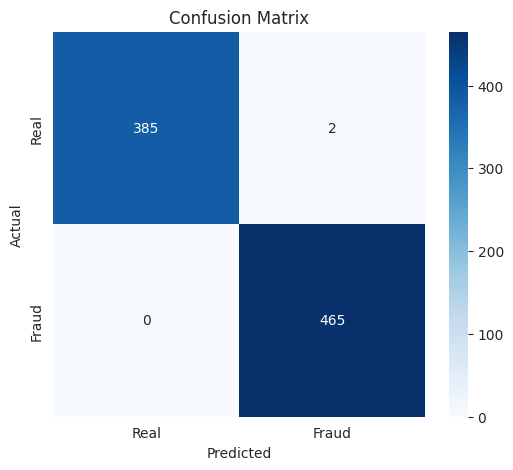

In [45]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_final_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Real', 'Fraud'], yticklabels=['Real', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


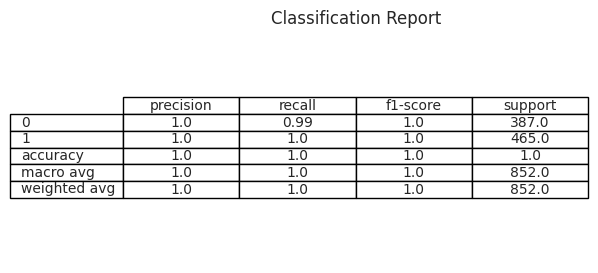

In [50]:
from sklearn.metrics import classification_report
import pandas as pd

# Generate classification report as a dictionary
report_dict = classification_report(y_test, y_final_pred, output_dict=True)

# Convert to a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Display as a table
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 3))  # Adjust size if needed
ax.axis('tight')
ax.axis('off')
ax.table(cellText=report_df.round(2).values, 
         colLabels=report_df.columns, 
         rowLabels=report_df.index, 
         cellLoc='center', loc='center')

plt.title("Classification Report")
plt.show()



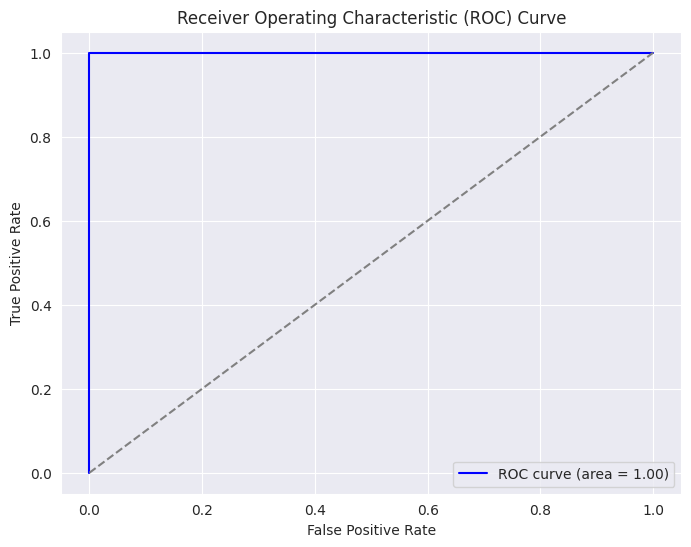

In [49]:
from sklearn.metrics import roc_curve, auc

# Compute probabilities
y_prob = best_model.predict_proba(X_test)[:, 1]  # Probability of fraud class (1)

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random model line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**AUC-ROC helps assess model quality:**

* Closer to 1 → Better fraud detection
* Closer to 0.5 → Model is guessing randomly

### **Final Conclusion & Next Steps**  

After training and evaluating multiple models (Logistic Regression, K-Nearest Neighbors, and Random Forest), we compared their performance using accuracy scores and a classification report. Based on our findings:  

✅ **Best Performing Model:** `Random Forest` with an accuracy of `0.98`.  
📊 **Key Metrics:** Precision, Recall, and F1-score were analyzed to understand model performance beyond accuracy.  
📉 **Confusion Matrix:** Helped in identifying misclassified instances, providing insights into model errors.  

### **Next Steps for Improvement**
🔹 **Feature Engineering:** Explore additional text-based features using NLP techniques (TF-IDF, Word Embeddings).  
🔹 **Hyperparameter Tuning:** Fine-tune model parameters (e.g., GridSearchCV) for better performance.  
🔹 **Deploying the Model:** Integrate the best-performing model into a web app or API for real-world usage.  
🔹 **Continuous Learning:** Implement model retraining using new job postings to maintain accuracy.  